In [2]:
#Data Science Project 26/06/2020 

#Viktoria Akpan ,Nicola Brioni


import string
from bs4 import BeautifulSoup
import re
import sklearn
from nltk.corpus import stopwords
from nltk.stem.porter import *
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from glob import glob
import pandas as pd 
from pathlib import Path
import nltk
#uncomment this, if your computer doesnt have nltk. a popup window will download it
#nltk.download()
import bs4 as bs
#import urllib.request
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn import metrics
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
#!pip install wordcloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix

#read in multiple files 
directory_in_str = r'C:\Users\User\Downloads\ECONOMETRICS\AA DS PROJECT NLP\sgm_Files\sgm_Files\\'

def readInAllFilesFromFolder(directory_in_str):
    pathlist = Path(directory_in_str).glob('**\*.sgm')
    #initialize file where individual string texts will be added
    file = ""
    for path in pathlist:   
        path_in_str = str(path)
        fileX = open(path_in_str,'r')
        fileX = fileX.read()    
        file= file+ fileX
    return file
    
file = readInAllFilesFromFolder(directory_in_str)


document = BeautifulSoup(file,'html.parser')
all_articles = document.find_all('reuters')
topics_body = []

for article in all_articles:
      topics_body.append([str(article.topics), str(article.body)])

topics_body = [tup for tup in topics_body if tup[0] != "<topics></topics>" #deleting empty topics articles
               and tup[1] != "None"]   #deleting empty-body articles


def cleanTopic(topics_body):   #removing the html tags 
    
    for i in range(len(topics_body)):
        topics_body[i][0] = topics_body[i][0].replace("<topics>","")
        topics_body[i][0] = topics_body[i][0].replace("</topics>","")
        topics_body[i][0] = topics_body[i][0].replace("<d>","")
        topics_body[i][0] = topics_body[i][0].replace("</d>","")



cleanTopic(topics_body)

# cleaning bodies 
for i in range(len(topics_body)):  #making everything in lower case
     topics_body[i][1] = topics_body[i][1].lower()
    
for i in range(len(topics_body)):  #removing html tags + "reuter"
    topics_body[i][1] = topics_body[i][1].replace("<body>",'')
    topics_body[i][1] = topics_body[i][1].replace("</body>",'')



table = str.maketrans('', '', string.punctuation) #eliminating punctuation
for i in range(len(topics_body)):
    
    topics_body[i][1] = topics_body[i][1].translate(table)



#changing all numbers to "num"
for i in range(len(topics_body)):  
    topics_body[i][1] = re.sub(r'\d+', 'num', topics_body[i][1])




stopwords = set(stopwords.words('english') + ['reuter', '\x03', 'num', 'said']) #removing stopwords     
for i in range(len(topics_body)):
    #tokenize articles
    topics_body[i][1] = [word for word in topics_body[i][1].split() if word not in stopwords]

    
#rejoin words
stemmer = PorterStemmer() #stemming + turning articles back into strings
for i in range(len(topics_body)):
    topics_body[i][1] = " ".join([stemmer.stem(word) for word in topics_body[i][1]])
    

#make data list into a df, for easier manipulation
def put_dataList_into_df(topics_body):
    df = pd.DataFrame(topics_body) 
    df.columns = ['topic', 'text']
    df = df[['text', 'topic']]  
    return df

df = put_dataList_into_df (topics_body)
 
    

#FIND ALL MIXED TOPICS W 'MONEY-FX' IN IT 
listOfAllTopics = pd.unique(df.topic) 
# initializing substring 
substring_money = 'money'
substring_money_fx =  'money-fx'
# using filter() + lambda  to get string with substring  
multiple_topics_contains_money = list(filter(lambda x: substring_money in x, listOfAllTopics)) 
multiple_topics_contains_money_fx = list(filter(lambda x: substring_money_fx in x, listOfAllTopics)) 
not_money_fx_topics = list(set(listOfAllTopics) - set(multiple_topics_contains_money_fx))


#make binary cloumn of topic being about money-fx or containing it
def setBinaryColumnForListOfTopics(df, topicsToBe1): 
     #input is a list or a single topic in brackets as ['money-fx']
    df['binaryTopic']=0 
    for aTopic in topicsToBe1:
        df.loc[df.topic == aTopic, 'binaryTopic'] = 1
    return df

df =setBinaryColumnForListOfTopics(df, multiple_topics_contains_money_fx)#input is a list or a single topic in brackets as ['money-fx']


C:\Users\User\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


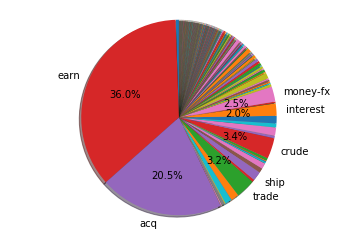

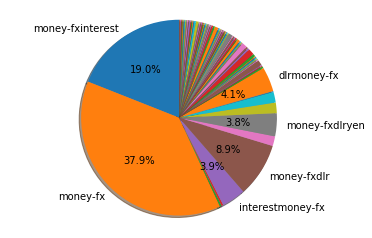

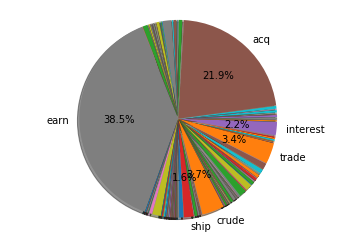

In [3]:
def makeListMoreTopicsWithMoreArticles(minArticles, listOfTopicsToInvestigateForEnoughData):
    list = []
    for aTopic in listOfTopicsToInvestigateForEnoughData:
        if    ((df[df.topic == aTopic].text.count()))>minArticles:
            list.append(aTopic)
        else:
            list.append('')
    return list

#https://matplotlib.org/3.1.1/gallery/pie_and_polar_charts/pie_features.html

def makePieChart(minArticles, listOfTopicsToInvestigateForEnoughData, minPercentageToShow):
    
    labels = makeListMoreTopicsWithMoreArticles(minArticles, listOfTopicsToInvestigateForEnoughData)
    sizeList=[]
    for aTopic in listOfTopicsToInvestigateForEnoughData:
        sizeList.append ((df[df.topic == aTopic].text.count()))
    sizes = sizeList
    #explode = (0, 0.1, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')
    def make_autopct(): 
        def my_autopct(pct):
            total = sum(sizes)
            val = int(round(pct*total/100.0))
            return ('%1.1f%%' %pct) if pct >minPercentageToShow else ''
        return my_autopct
    
    fig1, ax1 = plt.subplots()
    ax1.pie(sizes, labels=labels,autopct=make_autopct(),shadow=True, startangle=90) #, explode=explode , autopct='%1.1f%%'
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

    plt.show()
makePieChart(150, listOfAllTopics, 2)
makePieChart(20, multiple_topics_contains_money_fx, 3)
makePieChart(140, not_money_fx_topics, 1.5)

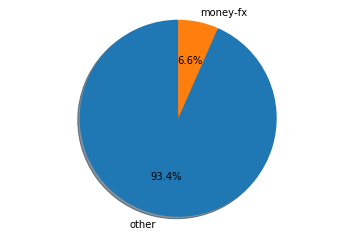

In [4]:
#PLOTBINARY DISTRIBUTION


sizeList=[]
#for aTopic in not_money_fx_topics:
sizeList.append ((df[df.binaryTopic == 0].text.count()))
    

sizeList.append ((df[df.binaryTopic == 1].text.count()))
#multiple_topics_contains_money_fx

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = ['other', 'money-fx']

#labels =  ListOfNOTMoney_fxTopicsW_minArticles #not_money_fx_topics
#sizes = [15, 30, 45, 10]
sizes = sizeList
#explode = (0, 0.1, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',shadow=True, startangle=90) #, explode=explode
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

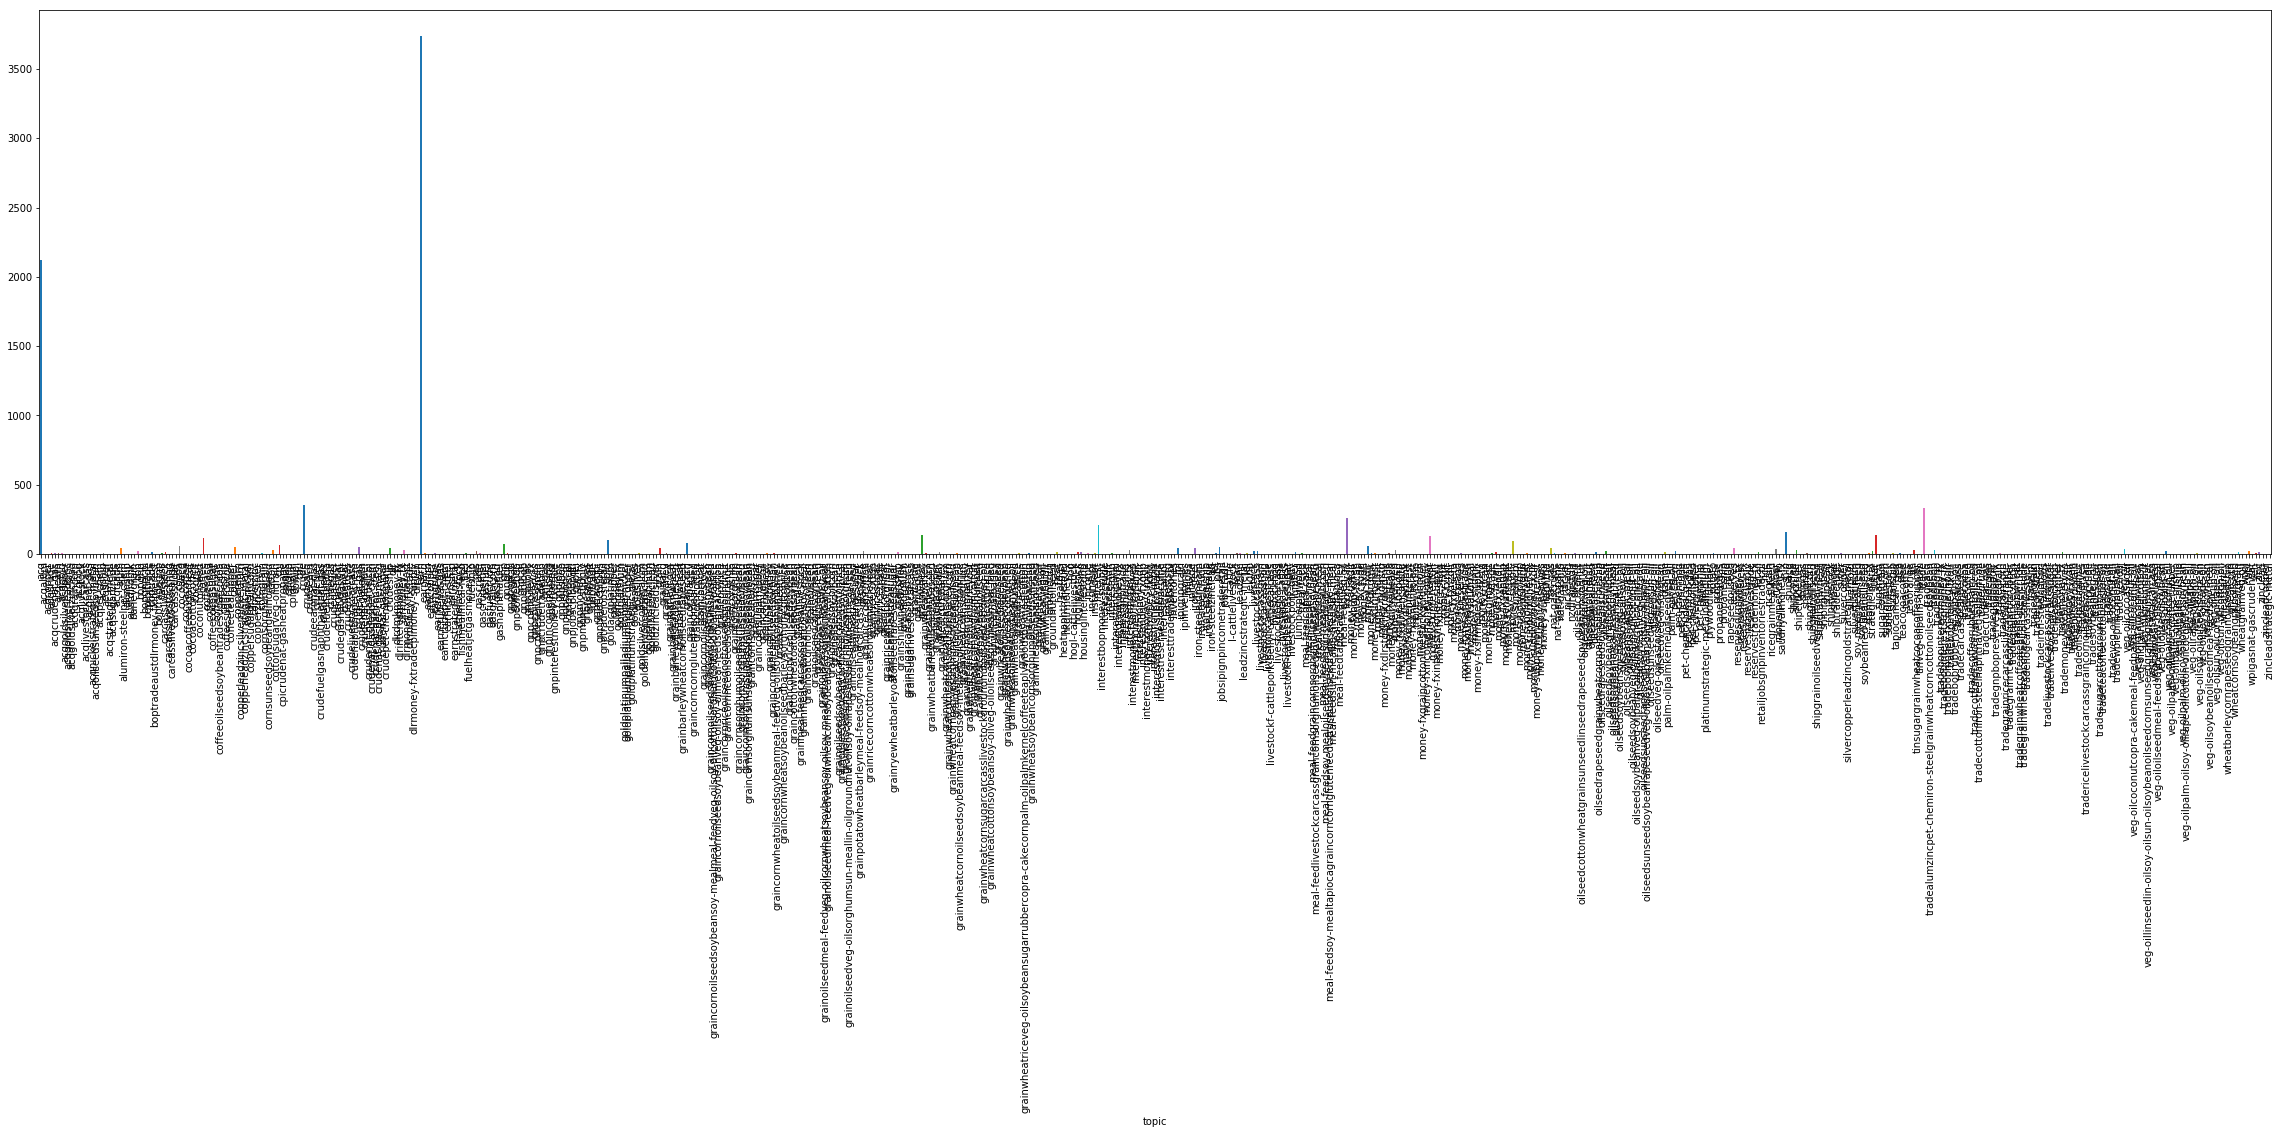

In [5]:
#number off articles per topic- visualize  
#Imbalanced Classes / https://towardsdatascience.com/multi-class-text-classification-with-scikit-learn-12f1e60e0a9f

def plotNumberOfArticlesPerClass(df):
    import matplotlib.pyplot as plt
    fig = plt.figure(figsize=(40,10))
    df.groupby('topic').text.count().plot.bar(ylim=0)
    plt.show()
plotNumberOfArticlesPerClass(df)

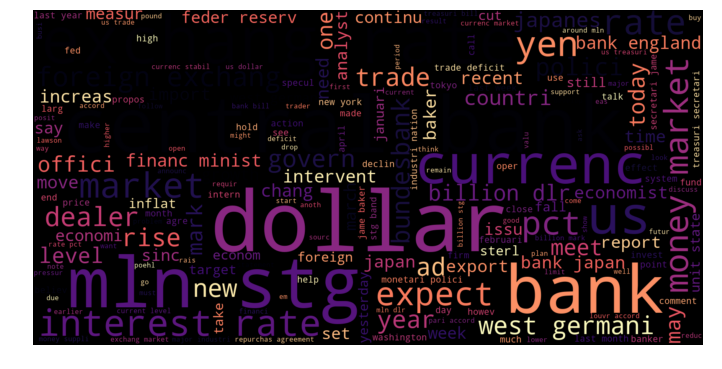

In [6]:
#word plot of all topics containing own topic
#https://github.com/tthustla/twitter_sentiment_analysis_part2/blob/master/Capstone_part3-Copy1.ipynb
#later STEPS: 1.make 1 topic of with all multi topics containing money fx, but not precisely it for comparison
#2.in the other topics, have no multitipoics containing money-fx

#conculsion from word map: said and num were very common, so I added them to the stopwords to be taken out. after the call, 
# seperating it into types and looking at its effect came up, which seems like a good idea

my_df=df
#for aTopic in multiple_topics_contains_money_fx:
    #neg_tweets = my_df[my_df.topic == aTopic]
neg_tweets = my_df[my_df.binaryTopic == 1]
neg_string = []
for t in neg_tweets.text:
    neg_string.append(t)
neg_string = pd.Series(neg_string).str.cat(sep=' ')
from wordcloud import WordCloud

wordcloud = WordCloud(width=1600, height=800,max_font_size=200,colormap='magma').generate(neg_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

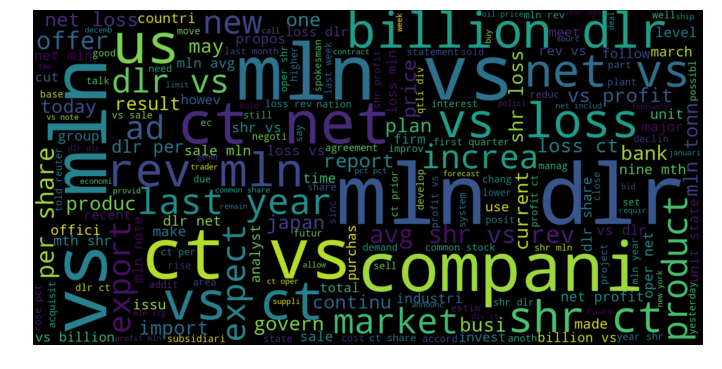

In [7]:
#all topics that are not money-fx
my_df=df
#for aTopic in not_money_fx_topics:
  #  pos_tweets = my_df[my_df.topic == aTopic]
pos_tweets = my_df[my_df.binaryTopic == 0]
pos_string = []
for t in pos_tweets.text:
    pos_string.append(t)
pos_string = pd.Series(pos_string).str.cat(sep=' ')
wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(pos_string)  #,colormap='magma'
plt.figure(figsize=(12,10)) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis("off") 
plt.show()

In [8]:
#term frequency vis (for zipfs law?)
#https://github.com/tthustla/twitter_sentiment_analysis_part2/blob/master/Capstone_part3-Copy1.ipynb
from sklearn.feature_extraction.text import CountVectorizer
cvec = CountVectorizer()
cvec.fit(my_df.text)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [9]:
len(cvec.get_feature_names())

23245

In [10]:
###play around, get freq of of both sides
#df.binaryTopic==1

In [11]:
import numpy as np


neg_doc_matrix = cvec.transform(df[df.binaryTopic==0].text)
pos_doc_matrix = cvec.transform(df[df.binaryTopic==1].text)

#neg_doc_matrix = cvec.transform(my_df[my_df.topic == "money-fx"].text)
#pos_doc_matrix = cvec.transform(my_df[my_df.topic !=  "money-fx"].text)
neg_tf = np.sum(neg_doc_matrix,axis=0)
pos_tf = np.sum(pos_doc_matrix,axis=0)
neg = np.squeeze(np.asarray(neg_tf))
pos = np.squeeze(np.asarray(pos_tf))
term_freq_df = pd.DataFrame([neg,pos],columns=cvec.get_feature_names()).transpose()

In [12]:
#zips law needs total word count column to arange by

term_freq_df['total'] = term_freq_df[0] + term_freq_df[1]
#term_freq_df.sort_values(by='total', ascending=False).iloc[:10]

print(term_freq_df.sort_values(by=0, ascending=False).iloc[:10])
print(term_freq_df.sort_values(by=1, ascending=False).iloc[:10])

             0    1  total
mln      17923  571  18494
vs       14169    0  14169
dlr      13235  339  13574
pct       8811  904   9715
ct        8273    3   8276
year      7240  352   7592
share     5689   30   5719
compani   5644   41   5685
net       5459   33   5492
billion   5436  562   5998
            0     1  total
bank     3000  1759   4759
dollar    589  1313   1902
rate     1935  1284   3219
market   2927  1078   4005
pct      8811   904   9715
us       4488   897   5385
currenc   405   808   1213
trade    3467   681   4148
exchang  1146   653   1799
would    4468   634   5102


Text(0.5,1,'Top 100 words in corpus')

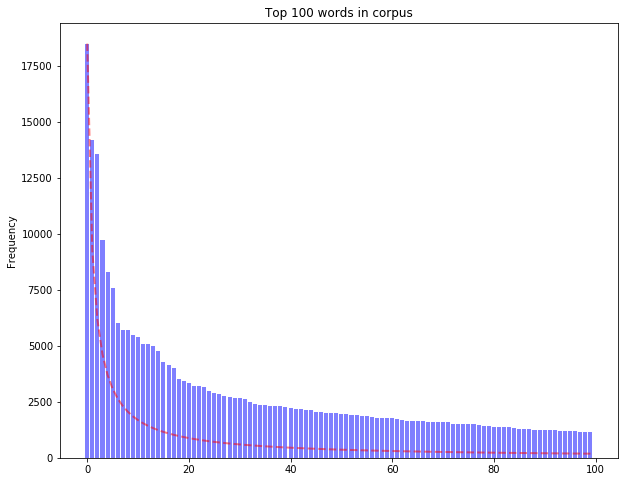

In [13]:
#zipf s law

y_pos = np.arange(100)
plt.figure(figsize=(10,8))
s = 1
expected_zipf = [term_freq_df.sort_values(by='total', ascending=False)['total'][0]/(i+1)**s for i in y_pos]
plt.bar(y_pos, term_freq_df.sort_values(by='total', ascending=False)['total'][:100], align='center', alpha=0.5,color='b')
plt.plot(y_pos, expected_zipf, color='r', linestyle='--',linewidth=2,alpha=0.5)
plt.ylabel('Frequency')
plt.title('Top 100 words in corpus')

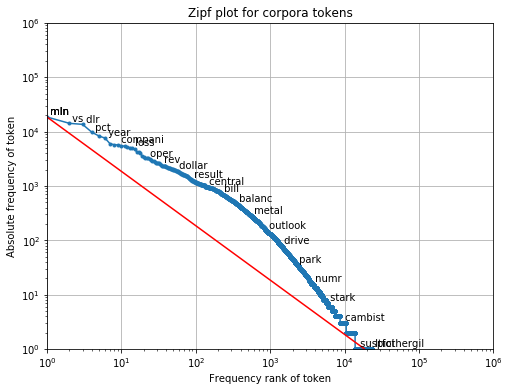

In [14]:
#zipf log - log graph
#"it mean that this text uses frequent words more heavily than other text corpora"

from pylab import *
counts = term_freq_df.total
tokens = term_freq_df.index
ranks = arange(1, len(counts)+1)
indices = argsort(-counts)
frequencies = counts[indices]
plt.figure(figsize=(8,6))
plt.ylim(1,10**6)
plt.xlim(1,10**6)
loglog(ranks, frequencies, marker=".")
plt.plot([1,frequencies[0]],[frequencies[0],1],color='r')
title("Zipf plot for corpora tokens")
xlabel("Frequency rank of token")
ylabel("Absolute frequency of token")
grid(True)
for n in list(logspace(-0.5, log10(len(counts)-2), 25).astype(int)):
    dummy = text(ranks[n], frequencies[n], " " + tokens[indices[n]], 
                 verticalalignment="bottom",
                 horizontalalignment="left")

In [15]:
#stuff for ml -ML input make w td idf
from sklearn.feature_extraction.text import TfidfVectorizer


def createML_input_w_tfidf(df):

    tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1')#, ngram_range=(1, 2), stop_words='english')
    features = tfidf.fit_transform(df.text).toarray()
    y = df.binaryTopic
    return features,y
    
features,y = createML_input_w_tfidf(df)

def splitDataForTestTrain(features, y):
    X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, y, df.index, test_size=0.20, random_state=0)
    return X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test =splitDataForTestTrain(features, y)
    

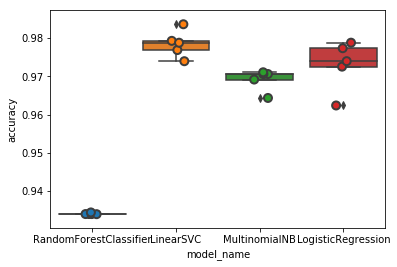

In [16]:
#model selection  ARTICLE 1 https://towardsdatascience.com/multi-class-text-classification-with-scikit-learn-12f1e60e0a9f

import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score

#needs  features, labels that are vectorized form of df
#STEPS: weight a model or add a weighted model from imblearn library
def plotModelAccuracies(features, y):
    models = [
        RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
        LinearSVC(),
        MultinomialNB(),
        LogisticRegression(random_state=0),
    ]
    CV = 5
    cv_df = pd.DataFrame(index=range(CV * len(models)))
    entries = []
    for model in models:
        model_name = model.__class__.__name__
        accuracies = cross_val_score(model, features, y, scoring='accuracy', cv=CV) ###make labels, feutures
        for fold_idx, accuracy in enumerate(accuracies):
            entries.append((model_name, fold_idx, accuracy))
    cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
    import seaborn as sns
    sns.boxplot(x='model_name', y='accuracy', data=cv_df)
    sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
                  size=8, jitter=True, edgecolor="gray", linewidth=2)
    plt.show()
    return cv_df, model_name
cv_df, model_name = plotModelAccuracies(features,y)

In [17]:
#only works if cv df from prev function is made global var
cv_df.groupby('model_name').accuracy.mean() #probs its so low bc of so few data for some topics

model_name
LinearSVC                 0.978509
LogisticRegression        0.973015
MultinomialNB             0.969163
RandomForestClassifier    0.934085
Name: accuracy, dtype: float64

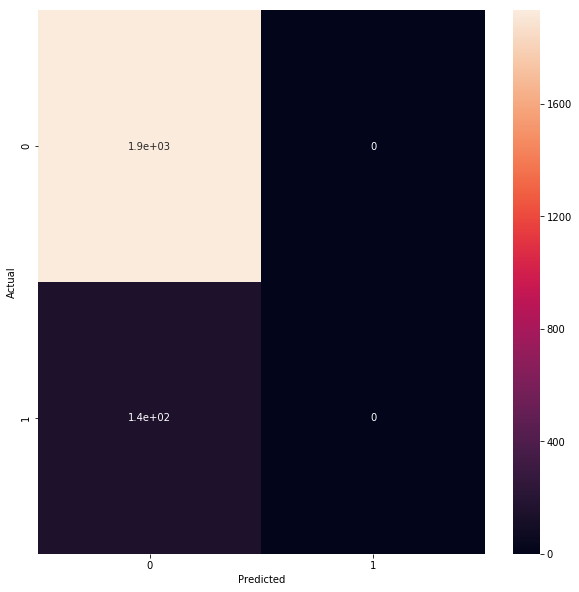

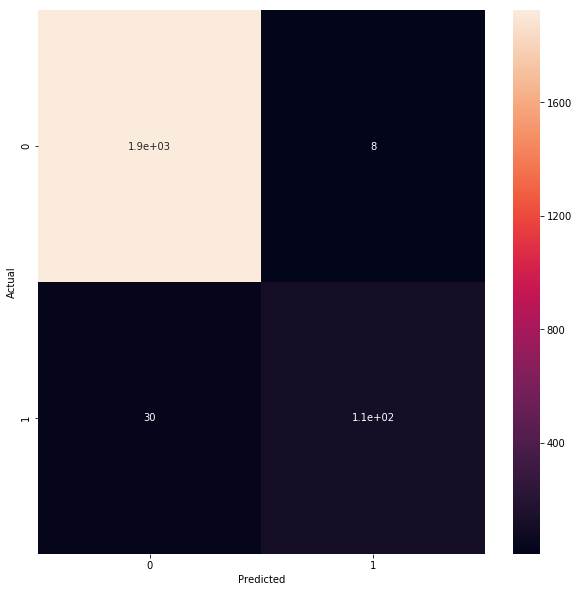

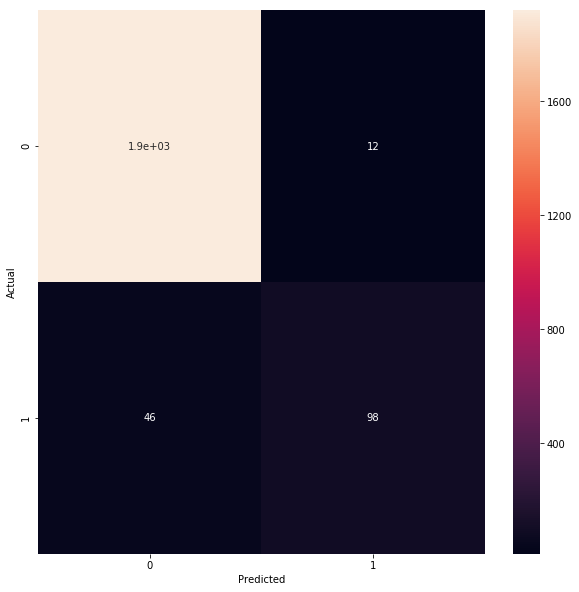

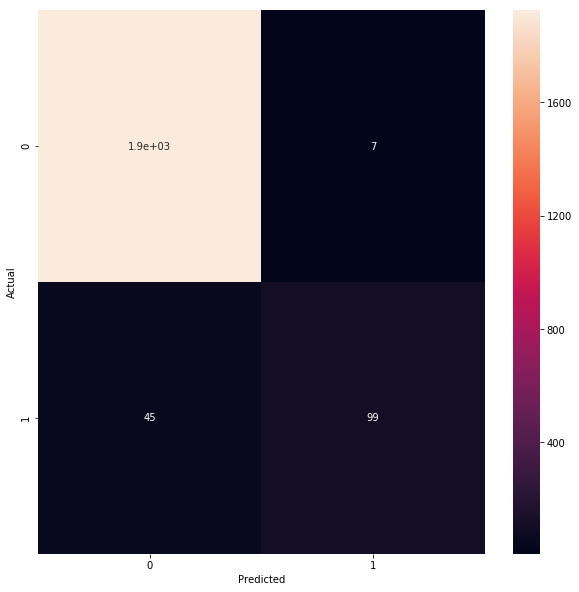

In [26]:
# MAKE conf matrix TAKE ANY MODEL

#confusion matrix
def makeConfusionMatrixOfSVC(features, y, df, model):
    #model = LinearSVC() #made it balanced for class imbalance  class_weight='balanced'
    X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, y, df.index, test_size=0.20, random_state=0)
    model.fit(X_train, y_train) #feuters is td idf vectorised matrix, y is extra numerized columm of topic id-s
    y_pred = model.predict(X_test) ###ONLY ROWS TO CHANGE Y TEST AND X TEST
    
    conf_mat = confusion_matrix(y_test, y_pred) ###ONLY ROWS TO CHANGE Y TEST AND X TEST,  y=[2, 5,13]
    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(conf_mat, annot=True)#, fmt='d',xticky=df.binaryTopic.values, yticky=df.binaryTopic.values)
                #xticky=category_id_df.topic.values, yticky=category_id_df.topic.values)
                
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
    return y_pred
y_pred_random_forest = makeConfusionMatrixOfSVC(features, y, df, RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0) )
y_pred_SVC = makeConfusionMatrixOfSVC(features, y, df,LinearSVC() )
y_pred_MultinomialNB = makeConfusionMatrixOfSVC(features, y, df, MultinomialNB() )
y_pred_logistic = makeConfusionMatrixOfSVC(features, y, df,LogisticRegression(random_state=0) )

#this is only test data, so there are less observations classified than in the data. try leave 1 out classification

In [44]:
###plaaaay
               
print("RandomForestClassifier"+ metrics.classification_report(y_test, y_pred_random_forest )) #random forest gets completely fucked, ptredicts no ones
print("LinearSVC "+metrics.classification_report(y_test, y_pred_SVC )) #SVC IS NOT FUCKED UP
print("MultinomialNB  "+metrics.classification_report(y_test, y_pred_MultinomialNB )) 
print("LogisticRegression"+metrics.classification_report(y_test, y_pred_logistic )) 

RandomForestClassifier             precision    recall  f1-score   support

          0       0.93      1.00      0.96      1932
          1       0.00      0.00      0.00       144

avg / total       0.87      0.93      0.90      2076

LinearSVC              precision    recall  f1-score   support

          0       0.98      1.00      0.99      1932
          1       0.93      0.79      0.86       144

avg / total       0.98      0.98      0.98      2076

MultinomialNB               precision    recall  f1-score   support

          0       0.98      0.99      0.99      1932
          1       0.89      0.68      0.77       144

avg / total       0.97      0.97      0.97      2076

LogisticRegression             precision    recall  f1-score   support

          0       0.98      1.00      0.99      1932
          1       0.93      0.69      0.79       144

avg / total       0.97      0.97      0.97      2076



C:\Users\User\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
